In [2]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import duckdb

In [6]:
# load the data
with h5py.File('../output/full_2017/clusters.h5', 'r') as f:
    clusters = f['clusters'][:]

topic_naming = json.load(open('../output/full_2017/topic_naming.json'))

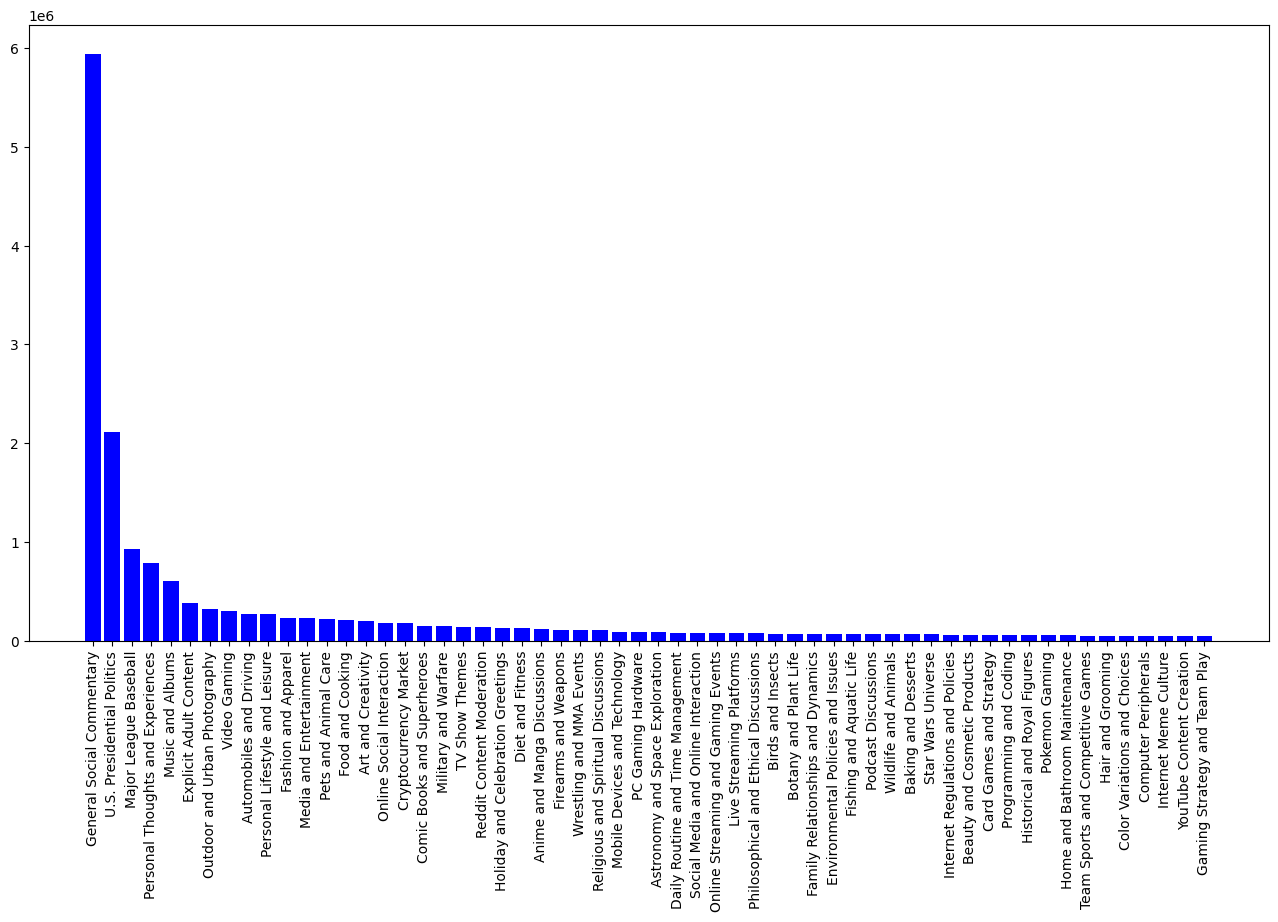

In [57]:
# sort by cluster size

cluster_size = np.bincount(clusters + 1)
sorted_clusters = np.argsort(cluster_size)[::-1]
sorted_cluster_size = cluster_size[sorted_clusters]
sorted_topic_naming = {k: topic_naming[k-1] for k in sorted_clusters}

plt.figure(figsize=(16, 8))  # Optional: adjusts the size of the figure
plt.bar(list(sorted_topic_naming.values()), sorted_cluster_size, color='blue')  # Creates a bar chart with blue bars

plt.xticks(rotation=90)  # Rotates the x-axis labels
plt.show()

In [3]:
# load all ids corresopnding to a group, see how the number of posts changed over time

def create_database_connection(parquet_directory:str, table_name:str):
    """Create and return a database connection using the provided configuration."""
    files = [f'{parquet_directory}/{file}' for file in os.listdir(parquet_directory)]

    con = duckdb.connect(database=':memory:')

    # Construct a SQL statement to read all files
    query_files = ', '.join(f"'{f}'" for f in files)
    sql_query = f"CREATE TABLE {table_name} AS SELECT author, id, title, selftext, score, num_comments, subreddit, created_utc  FROM read_parquet([{query_files}], union_by_name=True)"
    con.execute(sql_query)
    return con

TABLE_NAME = 'submissions'

# get id for topic 'U.S. Presidential Election'



con = create_database_connection('../data/big_test', TABLE_NAME)
placeholders = ','.join(['?'] * len(cluster_ids))  # Prepare placeholders for SQL query
query = f"SELECT created_utc, id FROM {TABLE_NAME} WHERE id IN ({placeholders})"
cursor = con.execute(query, cluster_ids)
posts = cursor.fetchall()
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
posts

[(1483228801, '5lcgjd'),
 (1483228802, '5lcgjf'),
 (1483228803, '5lcgji'),
 (1483228805, '5lcgjp'),
 (1483228805, '5lcgjr'),
 (1483228805, '5lcgjs'),
 (1483228806, '5lcgju'),
 (1483228806, '5lcgjv')]